In [3]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from amptorch.gaussian import Gaussian
from amptorch.skorch.model_skorch import FullNN, CustomLoss, TanhLoss
from amptorch.skorch.skorch_data import AtomsDataset, factorize_data, collate_amp, TestDataset
from amptorch.skorch.skorch_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots
from amptorch.skorch import AMP
from amptorch.lj_model import lj_optim
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
from ase.md import Langevin

In [4]:
# Functions needed to allow skorch to report energy and force rmse
def target_extractor(y):
    return (
        (to_numpy(y[0]), to_numpy(y[1]))
        if len(y) == 2
        else (to_numpy(y[0]), to_numpy(y[1]), to_numpy(y[2]))
    )

def energy_score(net, X, y):
    mse_loss = MSELoss(reduction="sum")
    energy_pred = net.infer()[0]
    device = energy_pred.device
    energy_target = torch.tensor(y[0]).to(device)
    num_atoms = torch.tensor(y[1]).to(device)
    dataset_size = len(energy_pred)
    sd_scaling = scalings[0]
    mean_scaling = scalings[1]
    raw_preds = (energy_pred * sd_scaling) + mean_scaling
    raw_preds_per_atom = torch.div(raw_preds, num_atoms)
    raw_targets = (energy_target * sd_scaling) + mean_scaling
    target_per_atom = torch.div(raw_targets, num_atoms)
    energy_loss = mse_loss(raw_preds_per_atom, target_per_atom)
    energy_loss /= dataset_size
    energy_rmse = torch.sqrt(energy_loss)
    return energy_rmse

def forces_score(net, X, y):
    mse_loss = MSELoss(reduction="sum")
    sd_scaling = scalings[0]
    force_pred = net.infer()[1] * sd_scaling
    device = force_pred.device
    num_atoms = torch.tensor(y[1]).to(device)
    force_target = torch.tensor(y[-1], device=device)
    dataset_size = len(num_atoms)
    raw_force_target = force_target * sd_scaling
    num_atoms_force = torch.cat([idx.repeat(int(idx)) for idx in num_atoms])
    num_atoms_force = torch.sqrt(num_atoms_force).reshape(len(num_atoms_force), 1)
    force_pred_per_atom = torch.div(force_pred, num_atoms_force)
    force_targets_per_atom = torch.div(raw_force_target, num_atoms_force)
    force_mse = mse_loss(force_pred_per_atom, force_targets_per_atom)
    force_mse /= 3 * dataset_size
    force_rmse = torch.sqrt(force_mse)
    return force_rmse

In [5]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 6.0

In [6]:
# LJ Optimization
def lj_optimization(images, Gs, label):
    cutoff = Gs["cutoff"]
    p0 = [
        1.33905162,
        0.12290683,
        6.41914719,
        0.64021468,
        0.08010004,
        8.26082762,
        2.29284676,
        0.29639983,
        0.08071821,
    ]
    params_dict = {"C": [], "O": [], "Cu": []}
    lj_model = lj_optim(images, p0, params_dict, cutoff, label)
    fitted_params = lj_model.fit()
    lj_energies, lj_forces, num_atoms = lj_model.lj_pred(
        images, fitted_params, params_dict
    )
    lj_data = [
        lj_energies,
        lj_forces,
        num_atoms,
        fitted_params,
        params_dict,
        lj_model,
    ]
    return lj_data

In [7]:
# Define Training data
label = "skorch_example"
images = ase.io.read("../../datasets/COCu/COCu_pbc_300K.traj", ":100")
lj_data = lj_optimization(images, Gs, label)
forcetraining = True
training_data = AtomsDataset(images, Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=1, lj_data=lj_data)
scalings = training_data.scalings
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

LJ optimization initiated...
Optimizer terminated successfully.
Calculating fingerprints...
Fingerprints Calculated!


In [13]:
net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 5, 5], device, forcetraining=forcetraining),
    criterion=TanhLoss,
    criterion__force_coefficient=0.3,
    optimizer=torch.optim.Adam,
    lr=1e-2,
    batch_size=100,
    max_epochs=500,
    iterator_train__collate_fn=collate_amp,
    iterator_valid__collate_fn=collate_amp,
    device=device,
    train_split=CVSplit(0.1),
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
    ],
)

In [14]:
# Define calculator and train
calc = AMP(training_data, net, label=label)
calc.train(overwrite=True)

  epoch    energy_score    forces_score    train_loss    valid_loss     dur
-------  --------------  --------------  ------------  ------------  ------
      1          0.0085          0.1541      484.1594       51.3036  0.2227
      2          0.0064          0.1552      436.1197       47.4052  0.2383
      3          0.0042          0.1449      400.4810       45.1354  0.2393
      4          0.0027          0.1335      377.8066       44.2821  0.2463
      5          0.0017          0.1181      368.9947       43.8494  0.2342
      6          0.0011          0.1025      364.7432       43.5824  0.2455
      7          0.0009          0.0898      362.6288       43.1749  0.2387
      8          0.0010          0.0765      361.6860       43.2645  0.2396
      9          0.0014          0.0639      362.5081       43.6980  0.2348
     10          0.0017          0.0568      363.7087       43.9188  0.2543
     11          0.0020          0.0535      364.7806       43.8103  0.2382
     12     

     86          0.0004          0.0414      336.2254       39.6543  0.2388
     87          0.0004          0.0414      335.1634       39.6009  0.2351
     88          0.0004          0.0417      335.3577       39.6440  0.2390
     89          0.0004          0.0418      335.3996       39.6945  0.2376
     90          0.0004          0.0418      335.2834       39.6533  0.2461
     91          0.0004          0.0416      334.5909       39.6245  0.2361
     92          0.0004          0.0415      334.7856       39.6739  0.2407
     93          0.0004          0.0417      334.2592       39.7673  0.2357
     94          0.0004          0.0415      334.3762       39.6532  0.2459
     95          0.0004          0.0415      334.0080       39.6067  0.2401
     96          0.0004          0.0417      333.4982       39.6128  0.2509
     97          0.0004          0.0416      333.4132       39.6018  0.2396
     98          0.0004          0.0417      332.9651       39.6179  0.2903
     99     

    184          0.0003          0.0434      318.1967       38.1475  0.2380
    185          0.0003          0.0433      317.9032       38.1216  0.2344
    186          0.0003          0.0435      317.8334       38.1034  0.2398
    187          0.0003          0.0435      318.0431       38.0488  0.2380
    188          0.0003          0.0433      317.5075       38.1248  0.2381
    189          0.0003          0.0433      317.6269       38.1738  0.2385
    190          0.0003          0.0433      317.5959       38.1153  0.2340
    191          0.0003          0.0438      317.7342       38.0979  0.2439
    192          0.0003          0.0429      317.8303       38.1125  0.2342
    193          0.0003          0.0440      317.9886       38.1062  0.2435
    194          0.0003          0.0430      317.4779       38.0996  0.2892
    195          0.0003          0.0436      317.1540       38.1017  0.2637
    196          0.0003          0.0438      317.0464       38.1118  0.2449
    197     

    288          0.0003          0.0424      314.4881       38.0424  0.2165
    289          0.0003          0.0430      314.8115       38.0930  0.2395
    290          0.0003          0.0422      315.2952       38.0068  0.2403
    291          0.0003          0.0431      314.5752       38.0110  0.2391
    292          0.0003          0.0426      314.6333       38.0203  0.2349
    293          0.0003          0.0429      314.5484       38.0917  0.2456
    294          0.0003          0.0431      314.8835       38.1705  0.2369
    295          0.0003          0.0424      314.9219       38.0474  0.2461
    296          0.0003          0.0435      315.2049       38.0640  0.2391
    297          0.0003          0.0421      315.4117       38.0043  0.2394
    298          0.0003          0.0432      315.0482       38.0908  0.2395
    299          0.0003          0.0423      314.5504       38.1185  0.2345
    300          0.0003          0.0428      314.5657       38.0047  0.2344
    301     

    393          0.0003          0.0417      316.4427       38.1467  0.2382
    394          0.0003          0.0425      314.3095       38.3721  0.2207
    395          0.0003          0.0415      316.7179       38.1738  0.2179
    396          0.0003          0.0425      315.7264       37.9934  0.2116
    397          0.0003          0.0417      314.5936       38.0438  0.2288
    398          0.0003          0.0423      315.3815       37.9665  0.2393
    399          0.0003          0.0417      314.3079       38.1036  0.2385
    400          0.0003          0.0425      315.2395       38.1578  0.2342
    401          0.0003          0.0415      315.4995       38.0786  0.2407
    402          0.0003          0.0425      314.4359       38.2057  0.2486
    403          0.0003          0.0415      315.4226       38.0859  0.2380
    404          0.0003          0.0425      314.7895       38.1354  0.2379
    405          0.0003          0.0416      314.2911       38.1073  0.2339
    406     

    500          0.0004          0.0418      313.2754       37.9883  0.2362


In [15]:
# MD Simulation
md_run(calc=calc, starting_image=images[0].copy(), temp=300, count=100, label=label)

In [16]:
# Calculate forces of base and generated trajectory
ml_images = ase.io.read(label+".traj", ":")
emt_energy, ml_apparent_energy, ml_actual_energy = calculate_energies(images, ml_images)
emt_forces, ml_apparent_forces, ml_actual_forces = calculate_forces(images, ml_images, type="max")

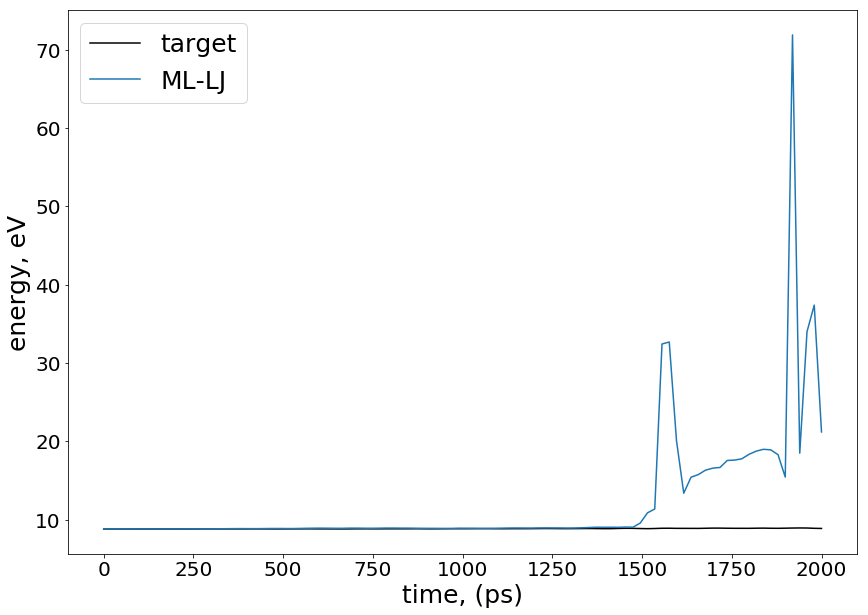

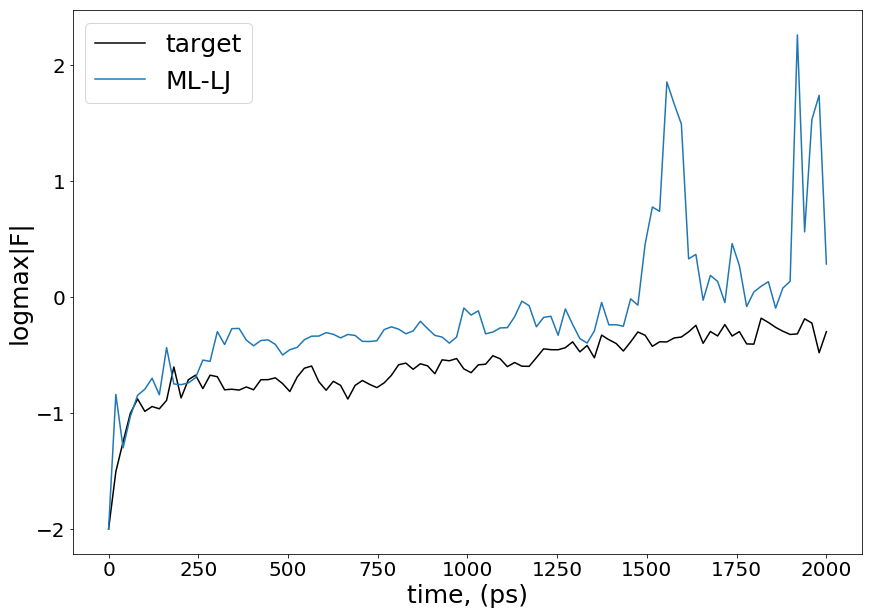

In [17]:
# Time Plots
import matplotlib.pyplot as plt
%matplotlib inline

time_plots(emt_energy, [ml_actual_energy], None, ['ML-LJ'], 'energy', None )
time_plots(emt_forces, [ml_actual_forces], None, ['ML-LJ'], 'forces', None )

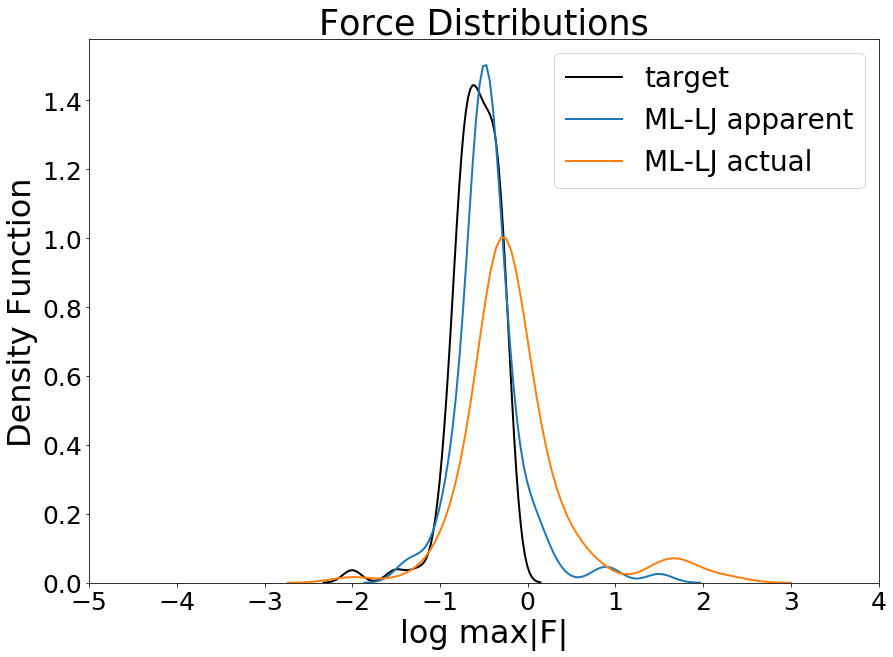

In [18]:
kde_plots(emt_forces, [ml_apparent_forces, ml_actual_forces] , ['ML-LJ apparent', 'ML-LJ actual'])

In [19]:
# Resample MD Simulation
import random
import copy
sample_points = random.sample(range(1, len(ml_images)), 10) #sample 10 points
images = ase.io.read("../../datasets/COCu/COCu_pbc_300K.traj", ":100")
resampled_images = copy.copy(images)
for i in sample_points:
    ml_image = ml_images[i].copy()
    ml_image.set_calculator(EMT())
    resampled_images.append(ml_image)

# Define Training data
label = "skorch_resample"
lj_data = lj_optimization(resampled_images, Gs, label)
forcetraining = True
training_data = AtomsDataset(images, Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=1, lj_data=lj_data)
scalings = training_data.scalings
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

# Train
net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 30, 30], device, forcetraining=forcetraining),
    criterion=CustomLoss,
    criterion__force_coefficient=0.3,
    optimizer=torch.optim.Adam,
    lr=1e-2,
    batch_size=400,
    max_epochs=500,
    iterator_train__collate_fn=collate_amp,
    iterator_valid__collate_fn=collate_amp,
    device=device,
    train_split=CVSplit(0.1),
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
    ],
)

# Define calculator and train
calc = AMP(training_data, net, label=label)
calc.train(overwrite=True)

LJ optimization initiated...
Optimizer terminated successfully.
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    valid_loss     dur
-------  --------------  --------------  ------------  ------------  ------
      1          0.0864         29.1448   348257.8125     1689.9625  0.4181
      2          0.1657         11.9067    58160.1641    16871.6777  0.3127
      3          0.1385         18.1605   135240.0312       19.2376  0.3061
      4          0.1508          1.0468      480.3737        9.2018  0.3033
      5          0.1553          1.2542      677.9186        9.2864  0.3127
      6          0.1498          0.7621      268.7701        5.8964  0.2961
      7          0.1442          4.7018     9091.7891    11385.7451  0.2824
      8          0.1370          1.4480      885.2792       19.9751  0.2840
      9          0.1283          0.5655      153.5846     2866.3867  0.2723
     10          0.1197          3.9339     636

     99          0.0068          0.2087       17.9214      125.4207  0.3056
    100          0.0068          0.2012       16.6584      121.2404  0.3031
    101          0.0068          0.1925       15.2593      117.1011  0.3093
    102          0.0068          0.1825       13.7217      113.2662  0.3070
    103          0.0068          0.1725       12.2620      109.9976  0.3081
    104          0.0067          0.1637       11.0503      107.4991  0.3059
    105          0.0067          0.1568       10.1429      105.8927  0.3007
    106          0.0067          0.1517        9.4934      105.1854  0.3102
    107          0.0067          0.1478        9.0163      105.2814  0.3032
    108          0.0067          0.1447        8.6411      106.0019  0.3035
    109          0.0067          0.1420        8.3265      107.1264  0.3006
    110          0.0067          0.1396        8.0524      108.4190  0.3114
    111          0.0067          0.1375        7.8093      109.6736  0.3020
    112     

    181          0.0063          0.0700        2.0643       31.0189  0.2864
    182          0.0063          0.0695        2.0324       30.2418  0.3104
    183          0.0063          0.0689        2.0015       29.4958  0.2921
    184          0.0063          0.0684        1.9715       28.7860  0.3008
    185          0.0063          0.0679        1.9423       28.1072  0.3031
    186          0.0063          0.0674        1.9141       27.4599  0.3469
    187          0.0063          0.0669        1.8867       26.8295  0.3066
    188          0.0062          0.0664        1.8600       26.2207  0.3060
    189          0.0062          0.0659        1.8343       25.6168  0.2955
    190          0.0062          0.0654        1.8093       25.0172  0.2982
    191          0.0062          0.0650        1.7851       24.4194  0.2915
    192          0.0062          0.0646        1.7616       23.8193  0.2999
    193          0.0062          0.0641        1.7389       23.2186  0.3011
    194     

    261          0.0059          0.0497        1.0613        2.6215  0.2925
    262          0.0059          0.0496        1.0567        2.5164  0.2863
    263          0.0059          0.0495        1.0522        2.4152  0.3124
    264          0.0059          0.0494        1.0478        2.3174  0.3704
    265          0.0059          0.0493        1.0434        2.2218  0.3362
    266          0.0059          0.0492        1.0391        2.1287  0.2967
    267          0.0059          0.0491        1.0348        2.0397  0.2954
    268          0.0059          0.0490        1.0306        1.9529  0.3009
    269          0.0059          0.0489        1.0265        1.8693  0.2990
    270          0.0059          0.0488        1.0224        1.7887  0.2935
    271          0.0059          0.0487        1.0184        1.7107  0.2935
    272          0.0059          0.0486        1.0144        1.6349  0.2824
    273          0.0058          0.0485        1.0105        1.5624  0.2709
    274     

    339          0.0056          0.0439        0.8315        0.0632  0.3116
    340          0.0056          0.0438        0.8296        0.0662  0.3159
    341          0.0056          0.0438        0.8277        0.0695  0.3036
    342          0.0056          0.0437        0.8259        0.0731  0.2936
    343          0.0056          0.0437        0.8241        0.0770  0.3231
    344          0.0056          0.0436        0.8223        0.0811  0.3428
    345          0.0056          0.0436        0.8205        0.0855  0.3224
    346          0.0056          0.0435        0.8187        0.0902  0.3158
    347          0.0056          0.0435        0.8170        0.0951  0.3129
    348          0.0056          0.0434        0.8152        0.1003  0.3116
    349          0.0056          0.0434        0.8135        0.1056  0.2722
    350          0.0056          0.0433        0.8118        0.1111  0.2923
    351          0.0056          0.0433        0.8101        0.1169  0.2864
    352     

    419          0.0054          0.0407        0.7194        0.6530  0.3078
    420          0.0054          0.0407        0.7183        0.6605  0.2734
    421          0.0054          0.0407        0.7173        0.6675  0.2951
    422          0.0054          0.0406        0.7162        0.6748  0.2988
    423          0.0054          0.0406        0.7152        0.6818  0.3083
    424          0.0054          0.0406        0.7141        0.6889  0.2912
    425          0.0054          0.0405        0.7131        0.6959  0.2987
    426          0.0054          0.0405        0.7120        0.7028  0.3909
    427          0.0054          0.0405        0.7110        0.7098  0.3001
    428          0.0054          0.0405        0.7100        0.7167  0.3043
    429          0.0054          0.0404        0.7090        0.7236  0.3035
    430          0.0053          0.0404        0.7080        0.7304  0.2897
    431          0.0053          0.0404        0.7069        0.7369  0.3081
    432     

    499          0.0052          0.0386        0.6477        1.0398  0.2780
    500          0.0052          0.0386        0.6470        1.0424  0.3054


In [20]:
# MD Simulation
md_run(calc=calc, starting_image=images[0].copy(), temp=300, count=100, label=label)

In [21]:
# Calculate forces of base and generated trajectory
ml_resample_images = ase.io.read(label+".traj", ":")
emt_energy, ml_r_apparent_energy, ml_r_actual_energy = calculate_energies(images, ml_resample_images)
emt_forces, ml_r_apparent_forces, ml_r_actual_forces = calculate_forces(images, ml_resample_images, type="max")

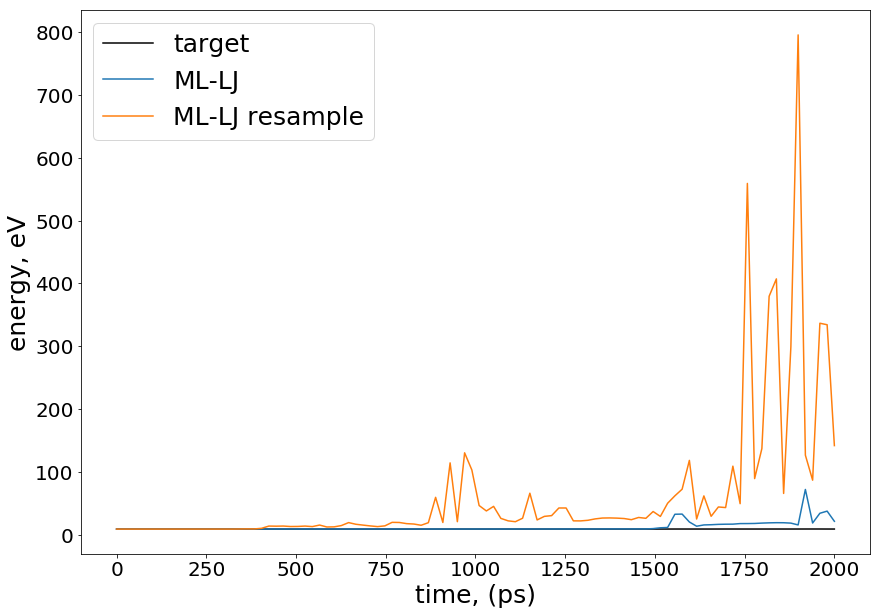

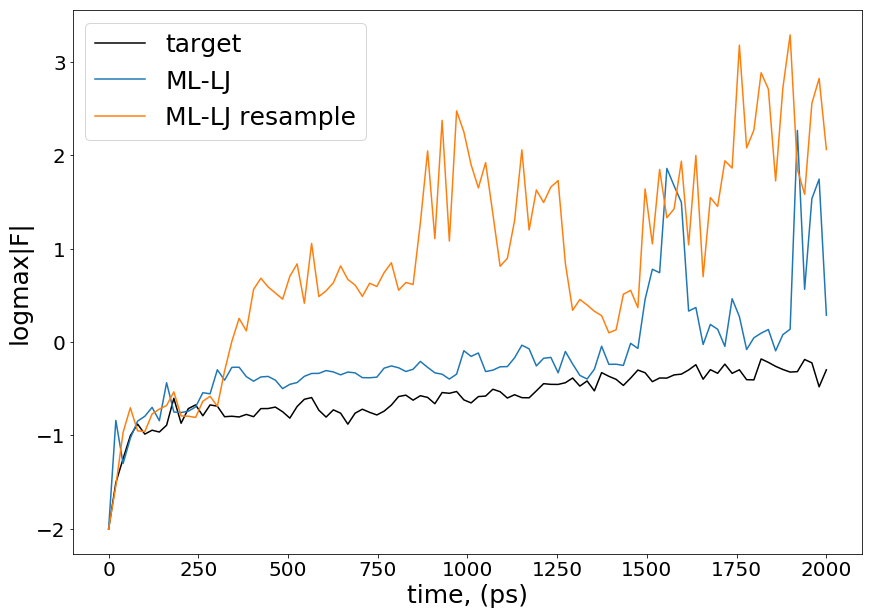

In [22]:
# Time Plots

time_plots(emt_energy, [ml_actual_energy, ml_r_actual_energy], None, ['ML-LJ', 'ML-LJ resample'], 'energy', None )
time_plots(emt_forces, [ml_actual_forces, ml_r_actual_forces], None, ['ML-LJ', 'ML-LJ resample'], 'forces', None )

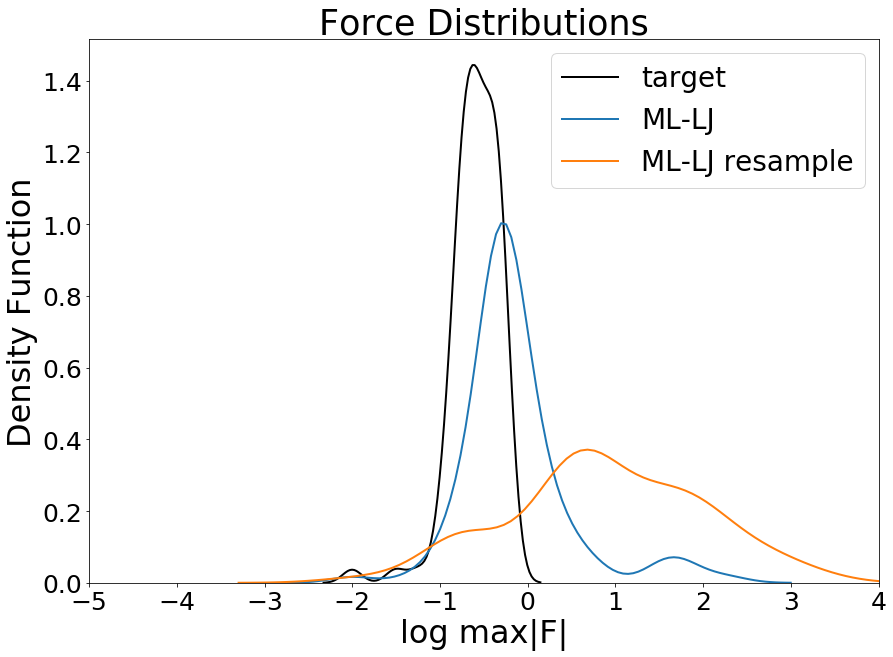

In [23]:
kde_plots(emt_forces, [ml_actual_forces, ml_r_actual_forces] , ['ML-LJ', 'ML-LJ resample'])